<a href="https://colab.research.google.com/github/bsong75/brendensong.github.io/blob/main/anomaly/anomaly_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Index(['Date', 'Power', 'Detector', 'Quality'], dtype='object')
       Date  Power  Detector Quality
0  1-Jan-16     96         8    Good
1  2-Jan-16     96        10    Good
2  3-Jan-16     91         8    Good
3  4-Jan-16     97         9    Good
4  5-Jan-16     91        11    Good


<Axes: title={'center': 'Detector Reading'}, ylabel='Frequency'>

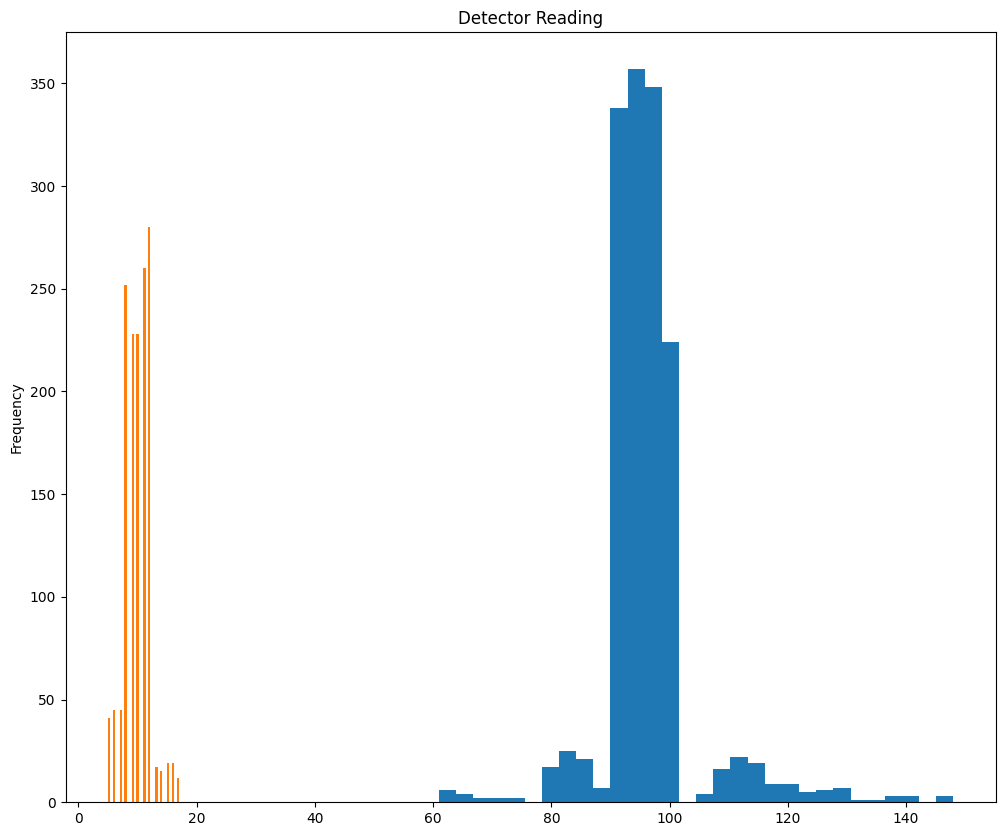

In [4]:

import pandas as pd
df = pd.read_csv('anomaly.csv')

print(df.columns)
print(df.head())
df['Power'].plot(kind='hist', title='Power Reading', bins=30, figsize=(12,10))
#Most values between 90 and 100 with some outliers / anomalies
df['Detector'].plot(kind='hist', title='Detector Reading', bins=30, figsize=(12,10))
#Most values between 8 and 12 with some outliers / anomalies




In [5]:
#To see how the data is spread betwen Good and Bad
print(df.groupby('Quality')['Quality'].count())

df.drop(['Date'], axis=1, inplace=True)
#print(df.head())

#If there are missing entries, drop them.
df.dropna(inplace=True,axis=1)


#COnvert non-numeric to numeric
df.Quality[df.Quality == 'Good'] = 1
df.Quality[df.Quality == 'Bad'] = 2


good_mask = df['Quality']== 1 #All good to be True for good data points
bad_mask = df['Quality']== 2 #All values False for good data points
#print(good_mask.head())

df.drop('Quality',axis=1,inplace=True)

df_good = df[good_mask]
df_bad = df[bad_mask]

print(f"Good count: {len(df_good)}")
print(f"Bad count: {len(df_bad)}")

# This is the feature vector that goes to the neural net
x_good = df_good.values
x_bad = df_bad.values

from sklearn.model_selection import train_test_split

x_good_train, x_good_test = train_test_split(
        x_good, test_size=0.25, random_state=42)

print(f"Good train count: {len(x_good_train)}")
print(f"Good test count: {len(x_good_test)}")


Quality
Bad      407
Good    1054
Name: Quality, dtype: int64
Good count: 1054
Bad count: 407


<ipython-input-5-e36f99a90944>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Quality[df.Quality == 'Good'] = 1
<ipython-input-5-e36f99a90944>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Quality[df.Quality == 'Bad'] = 2


Good train count: 790
Good test count: 264


In [6]:
#########
#Define the autoencoder model
#Since we're dealing with numeric values we can use only Dense layers.

from sklearn import metrics
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim=x_good.shape[1], activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(x_good.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

model.fit(x_good_train,x_good_train,verbose=1,epochs=100)

pred = model.predict(x_good_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_good_test))

pred = model.predict(x_good)
score2 = np.sqrt(metrics.mean_squared_error(pred,x_good))

pred = model.predict(x_bad)
score3 = np.sqrt(metrics.mean_squared_error(pred,x_bad))

print(f"Insample Good Score (RMSE): {score1}".format(score1))
print(f"Out of Sample Good Score (RMSE): {score2}")
print(f"Bad sample Score (RMSE): {score3}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
 dense_2 (Dense)             (None, 10)                40        
                                                                 
 dense_3 (Dense)             (None, 2)                 22        
                                                                 
Total params: 125 (500.00 Byte)
Trainable params: 125 (500.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
25/25 [==============================] - 1s 3ms/step - loss: 5890.2612
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - 